# Lab/ Audio/ Multi-Pitches estimation

Author: Geoffroy Peeters 

Last edit: 2020/11/04

## Introduction

L’objectif de ce TP est de réaliser un module d’estimation de fréquences fondamentales multiples d’un signal de musique (i.e. de déterminer à partir du signal audio les notes de musique jouées).
Il existe de nombreuses approches pour résoudre ce problème. 
Nous étudions ici une technique simple inspirée par les travaux de A. Klapuri [1, 2].

Cette approche consiste à 
- dans un premier temps estimer la fréquence fondamentale dominante
- à en déduire la position et l’amplitude de ses harmoniques sur le spectre 
- et à soustraire la contribution du son correspondant.

Ce principe est ensuite itéré à chaque fois sur le signal soustrait afin d’extraire progressivement l’ensemble des fréquences fondamentales.

Il est ensuite proposé de mettre en place le principe de la **continuité de l’enveloppe spectrale** (spectral smoothness) qui sera appliqué au préalable de la soustraction fréquentielle.

Les performances de ces approches seront testées et comparées sur différents accords composés de notes de piano, de flute et de hautbois.

La figure résume les différentes étapes de l’algorithme.
<IMG src='../_images/TP_multiPitch_schema.png'  width=600/>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io.wavfile
import scipy.signal as sig
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
# %matplotlib inline
import sys
# import tpt_tools
import re
import util as ut

from typing import List, Dict, Tuple

import IPython.display as ipd

do_student = True

Nous sélectionner le fichier audio à étudier.

In [2]:
def get_audio_single(f_path: str, pat: re.Pattern) -> Dict: 
    f_name = os.path.basename(f_path)
    m = re.match(pat, f_name)
    if m is None:
        raise AttributeError('Nope')
    g = m.groupdict()
    print(f_path)
    d = dict({g['instr']: dict({g['chord']: wav.read(f_path)})})
    return d

def get_audio(f_paths: str, pat: re.Pattern) -> Dict:
    dicts = [get_audio_single(p, pat) for p in f_paths]
    return ut.dict_merge(*dicts)


In [3]:
audio_path = '../_audio/'
audio_files = [os.path.abspath(os.path.join(audio_path, f)) for f in os.listdir(audio_path)]

audio_pat = re.compile(r'(?P<chord>\w+)_(?P<instr>\w+).wav')

audio_data = get_audio(audio_files, audio_pat)


/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A4_piano.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A3C4E4G4_piano.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A3A4A5_duo.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/E4_oboe.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A3A4_piano.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A3_piano.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/Accord_trio.wav
/home/xabbu/Documents/projets_gite/atiam/tp_signal/tp_multihauteur/_audio/A5_flute.wav


In [4]:
sr_hz, x = audio_data['piano']['A3C4E4G4']

h = 4
l_sec = 0.1

l_n = np.int64(l_sec*sr_hz)
n_fft = 4 * ut.next_pow2(l_n) 

ipd.Audio(x, rate=sr_hz)

# Estimation de la fréquence fondamentale par la méthode du produit spectral

Nous allons estimer ici la fréquence fondamentale $f_0$ d’un signal discret $x(n)$ échantillonné à la fréquence $sr_{hz}$.
La valeur $f_0$ sera recherchée dans un intervalle $[F_{min},F_{max}]$, avec une **précision** au moins égale à $dF$.
La valeur de $dF$ s'obtient à partir du nombre de points de la DFT et du taux d'échantillonnage $dF = \frac{sr_{hz}}{N_{fft}}$.
Par défaut, nous utiliserons $F_{min}$ = 50 Hz, $F_{max}$ = 900 Hz.

Nous allons utiliser la méthode du **produit spectral**.
Celui-ci est calculé en multipliant $H$ versions compressées du spectre. 

Si nous notons $f_k = \frac{k}{N_{fft}}$ les fréquences discrètes de la DFT, le produit spectral est donné par:
\begin{equation}
    P(f_k) = \prod_{h=1}^{H} |X(h \cdot f_k)|
\end{equation}
Par défaut nous utiliserons $H$ = 4.

Les différentes étapes de ce calcul sont détaillées ci-dessous.

## Calcul du spectre (TFD) du signal

Dans un premier temps, nous calculons la transformée de Fourier discrète (TFD) du signal $x(n)$ sur $N_{fft}$ points.
Nous commençons par multiplier $x(n)$ par une fenêtre de hamming de taille $L_n$ (ceci afin de diminuer la hauteur des lobes secondaires).

La longueur $L_n$ ainsi que le type de cette fenêtre détermine la **résolution fréquentielle**, i.e. le pouvoir de séparer en fréquence deux sinusoides adjacentes.

Le nombre de points de la la DFT, $N_{fft}$, détermine lui la **précision fréquentielle**., i.e. la distance en Hz entre $f_k$ et $f_{k+1}$.
Il faut impérativement utiliser une valeur de $N_{fft}$ supérieure à $L_n$. En pratique $N_{fft}$ est choisi comme une puissance de 2 de manière à pouvoir utiliser l'algorithme de FFT (Fast Fourier Transform). Ceci peut se calculer à l'aide de la fonction ```nextpow2```.

Calculer ensuite la transformée de Fourier Discrète $X(k)$.

In [51]:
def F_getSpectreFromAudio(x, l_n, n_fft, sr_hz):
    """
    inputs:
        - x: signal
        - L_n: window duration in samples
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftFreq_hz_v (N/2+1,): vector containing the DFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the DFT amplitudes
    """
    assert(l_n <= n_fft)    
    ### START CODE HERE ###    
    # Pour normaliser : la somme des échantillons de la fenêtre * 0.5
    w = sig.windows.hamming(l_n)
    x_w = x[:l_n] * w / np.sum(w)
    amps_ft = np.abs(np.fft.rfft(x_w, n=n_fft))
    fs_hz = np.fft.rfftfreq(n=n_fft) * sr_hz
    ### END CODE HERE ###
    return fs_hz, amps_ft

(0.0, 3000.0)

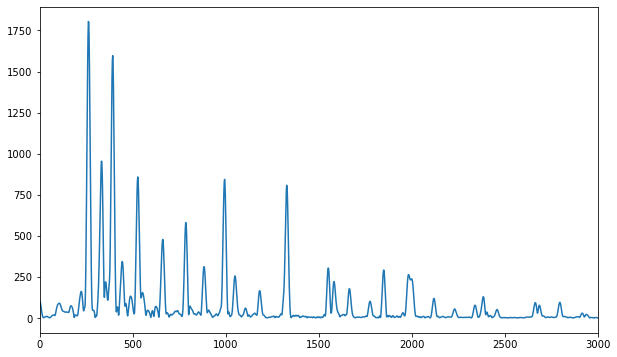

In [52]:
fs_hz, amps_ft = F_getSpectreFromAudio(x, l_n, n_fft, sr_hz)

# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10, 6))
# ut.F_plot1(fs, x_ft, 'Frequency [Hz]', 'Amplitude [lin]')
plt.plot(fs_hz, amps_ft)
plt.xlim((0,3000))
# +++++++++++++++++++++++++++++++


### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='../_images/TP_multiPitch_01.png' width=600/>

## Calcul du produit spectral et recherche du maximum du produit spectral

Le produit spectral $P$ sera codé dans un vecteur de longueur $R$, couvrant l'intervalle $[0, R-1]$.
La fréquence maximale intervenant dans le calcul de $P$ sera donc $H \frac{R-1}{N_{fft}} sr_{hz}$.

En déduire (en fonction de $N_{fft}$ et de $H$) la valeur maximale de $R$ qui garantit de ne pas dépasser la fréquence de Nyquist ($\frac{sr_{hz}}{2}$).
Calculer ensuite $P$ en fonction de $|X|$.

Déterminer les valeurs entières $N_{min}$ et $N_{max}$ qui correspondent à l’intervalle $[F_{min},F_{max}]$ (on veillera à ce que $N_{max}$ reste inférieur à $R$).
Rechercher le maximum de $P$ sur l’intervalle $[N_{min},N_{max}]$, et en déduire la valeur de la fréquence fondamentale $f_0$.

On testera la fonction de détection de la fréquence fondamentale sur des signaux monophoniques (par exemple A4\_piano.wav ou E4\_oboe.wav).

(0.0, 3000.0)

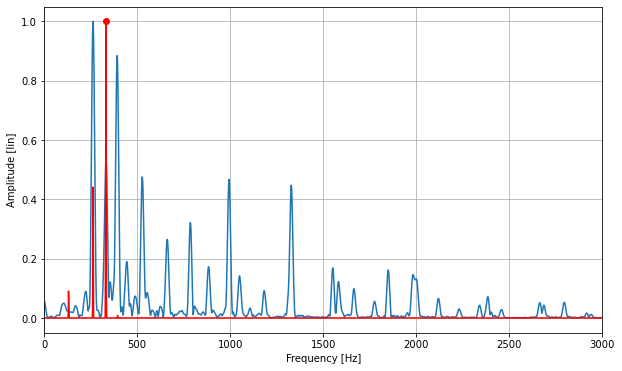

In [54]:
def spectral_product(fs_hz: np.ndarray, amps_ft: np.ndarray, r: int, h: int) -> np.array:
    """Get spectral product of input fourier transform

    Args:
        amps_ft (np.ndarray): [description]
        h (int): [description]

    Returns:
        np.array: [description]
    """
    p_p = np.zeros((h, r))
    for i in np.arange(h):
        p_p[i] = amps_ft_part = amps_ft[::(i+1)][:r]
    fs_p_hz = fs_hz[:r]
    p = np.prod(p_p, axis=0) ** 2 
    return fs_p_hz, p

def F_getF0FromSpectre(fs_hz, amps_ft, h, f_min_hz, f_max_hz, n_fft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - H: number of times the spectrum is decimated
        - fmin_hz: minimum frequency in Hz to look for F0
        - fmax_hz: maximum frequency in Hz to look for F0
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - spFreq_hz_v: vector containing the SpectralProduct frequencies in Hz
        - spAmpl_v: vector containing the SpectralProduct amplitudes 
        - f0_hz: estimated F0 in Hz
    """
    ### START CODE HERE ###        
    r = int(np.floor(n_fft / (2 * h) + 1))
    n_min = int(np.floor((f_min_hz / sr_hz) * n_fft))
    n_max = int(np.floor((f_max_hz / sr_hz) * n_fft)) + 1
    assert(n_max <= r)
    fs_p_hz, p = spectral_product(fs_hz, amps_ft, r, h)
    f_0_hz = fs_p_hz[n_min + np.argmax(p[n_min:n_max], axis=0)]
    ### END CODE HERE ###
    return fs_p_hz, p, f_0_hz

sr_hz, x = audio_data['piano']['A3C4E4G4']
# sr_hz, x = audio_data['piano']['A4']
h = 4
l_sec = 0.1
# Pour normaliser : la somme des échantillons de la fenêtre * 0.5
l_n = np.int64(l_sec*sr_hz)
n_fft = 4 * ut.next_pow2(l_n) 
#
fs_hz, amps_ft = F_getSpectreFromAudio(x, l_n, n_fft, sr_hz)
f_min_hz = 50
f_max_hz = 900
fs_p_hz, p, f_0_hz = F_getF0FromSpectre(fs_hz, amps_ft, h, f_min_hz, f_max_hz, n_fft, sr_hz)

# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10,6))
ut.F_plot1(fs_hz, amps_ft / np.max(amps_ft), 'Frequency [Hz]', 'Amplitude [lin]')
plt.plot(fs_p_hz, np.abs(p) / np.max(p), 'r')
plt.plot(f_0_hz, 1, 'ro')
plt.xlim((0,3000))
# +++++++++++++++++++++++++++++++


### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='../_images/TP_multiPitch_02.png' width=600/>

# Soustraction du son correspondant à la fréquence fondamentale détectée

Dans les cas des signaux polyphoniques, plusieurs spectres harmoniques sont superposés.
Nous allons donc soustraire du spectre total, celui correspondant au spectre harmonique dont nous venons d'avoir estimer la $f_0$.

## Détection des harmoniques

Pour cela, nous devons d'abord connaitre la position des harmoniques du son de fréquence fondamentale $f_0$.
Une procédure simple consiste à rechercher le maximum du spectre autour de chaque **harmonique théorique** de fréquence $f_h = h \cdot f_0$.

L’intervalle de recherche autour de chaque harmonique $f_h$ est donné par $[f_{kmin}:f_{kmax}]$. 
Afin de tenir compte de l'inharmonicité des sons, on pourra choisir
$$
f_{kmin} = (1-\alpha) f_{inharmo} \\
f_{kmax} = (1+\alpha) f_{inharmo}
$$
Avec :
$$
f_{inharmo} = h f_0 \sqrt{1+(h^2-1) \beta}
$$
Où $\beta$ est le coefficient d’inharmonicité (ce qui correspond à un bon modèle d’inharmonicité dans le cas du piano).

On pourra par ailleurs appliquer cette recherche également pour $h$ = 1 afin d’affiner l’estimation de $f_0$.

Quel choix de $\alpha$, $\beta$ vous parait judicieux pour le piano ? pour le hautbois ? 
Ce modèle de recherche des harmoniques vous parait-il judicieux ? Justifier.

**Résponse:**
Piano : $a \approx 10^{-2}, b \approx 10^{-3}$
Hautbois : $a \approx 10^{-3}, b \approx 10^{-2}$ car plus aigu.

(0.0, 3000.0)

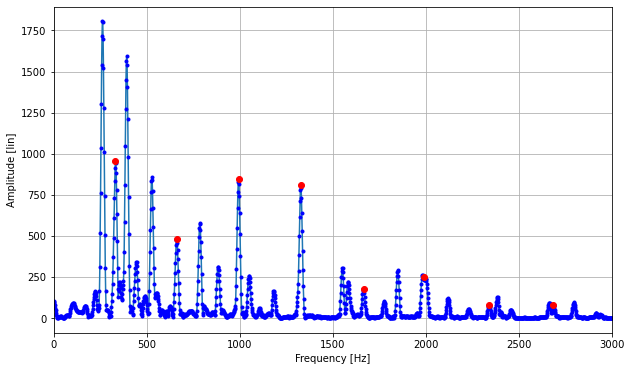

In [63]:
def get_max_nb_harmonics(f_0_hz: float, n_fft: int, sr_hz: float, alpha: float, beta: float) -> float:
    eta = (sr_hz / (2 * f_0_hz * (1 + alpha)))**2 / beta
    mu = 1 - 1/beta
    h = int(np.floor(np.sqrt((mu + np.sqrt(mu**2 + 4*eta))/2)))
    return h

def F_getHarmonicsFromF0AndSpectre(fs_hz, amps_ft, f_0_hz, n_fft, sr_hz, alpha: float, beta: float):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - f0_hz: estimated F0 in Hz
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
    """
    
    ### START CODE HERE ###            
    # first compute max h
    h = get_max_nb_harmonics(f_0_hz, n_fft, sr_hz, alpha, beta)
    #
    hs = np.arange(h)+1
    f_inharmo = hs * f_0_hz * np.sqrt(1 + (hs**2 - 1) * beta)

    f_k_min = (1 - alpha) * f_inharmo
    f_k_max = (1 + alpha) * f_inharmo
    n_k_min = np.floor((f_k_min / sr_hz) * n_fft).astype(int)
    n_k_max = np.floor((f_k_max / sr_hz) * n_fft).astype(int)+1


    amps_ft_chunks = [amps_ft[n_min:n_max] for (n_min, n_max) in np.nditer([n_k_min, n_k_max])]
    amps_h = np.array([np.amax(chunk, axis=0) for chunk in amps_ft_chunks])
    fs_h_k = (n_k_min + np.array([np.argmax(chunk, axis=0) for chunk in amps_ft_chunks])).astype(int)

    ### END CODE HERE ###            

    return fs_h_k, amps_h

alpha = 10**-2
beta = 5*10**-4
fs_h_k, amps_h = F_getHarmonicsFromF0AndSpectre(fs_hz, amps_ft, f_0_hz, n_fft, sr_hz, alpha, beta)

# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10,6))
ut.F_plot1(fs_hz, amps_ft, 'Frequency [Hz]', 'Amplitude [lin]')
plt.plot(fs_hz, np.abs(amps_ft), 'b.')
plt.plot(fs_hz[fs_h_k], np.abs(amps_h), 'ro')
plt.xlim((0,3000))
# +++++++++++++++++++++++++++++++

### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='../_images/TP_multiPitch_03.png' width=600/>

## Suppression des harmoniques

Il s’agit ensuite de supprimer la totalité des harmoniques $f_h$ correspondant à un son donné. 
- Pour cela, on calcul d'abord la largeur théorique d’un pic spectral (celui-ci dépend de la largeur $L_n$ de la fenêtre d’analyse utilisée). 
- Ensuite, pour chaque harmonique $f_h$, on annule le spectre sur cette largeur théorique centrée sur $f_h$. Nous notons $a_h$ et $b_h$ les bornes de cet interval.

En raison de la technique d’estimation de la fréquence fondamentale utilisée, la mise à zéro des harmoniques perturbe les itérations ultérieures de l’algorithme.
Pour cette raison, on remplacera la mise à zéro par le forçage des valeurs du spectre autour de chaque harmonique $f_h$ au minimum du spectre sur cet intervalle ($|X(a_h : b_h)| = \min(|X(a_h : b_h))|$).

## Suppression des harmoniques avec application du principe du "spectral smoothness"

Afin de mieux discerner les sons qui sont en relation harmonique (et notamment les sons à l’octave) il est préférable de ne pas soustraire totalement un son de la mixture, mais d’essayer de ne soustraire que sa contribution au niveau de chaque harmonique.
Pour cela, on utilise le principe de la **continuité de l’enveloppe spectrale ("spectral smoothness")**.

Celui-ci consiste à calculer un spectre harmonique lissé où l’amplitude du spectre au niveau de chaque harmonique $f_h$ est remplacée par la moyenne des amplitudes des harmoniques $f_{h-1}$, $f_h$ et $f_{h+1}$. Cette nouvelle valeur, notée $|\hat{X}(f_h)|$ représente mieux la contribution du son harmonique de fréquence fondamentale $f_0$ que celle issue directement du spectre, notée $|X(f_h)|$. En effet ce dernier peut être le résultat d'une superposition d'harmoniques de différents sons.

Ensuite, la soustraction spectrale consiste à:

– Si $|X(f_h)|$ est inférieure à $|\hat{X}(f_h)|$ nous forçons les valeurs du spectre autour de chaque harmonique $f_h$ au minimum du spectre sur cet intervalle ($|X(a_h : b_h)| = \min(|X(a_h : b_h))|$)

– Si $|X(f_h)|$ est supérieure à $|\hat{X}(f_h)|$ nous forçons les valeurs du spectre autour de chaque harmonique $f_h$ à la différence entre le spectre et le spectre lissé sur cet intervalle $[a_h : b_h]$; pour éviter les valeurs négatives nous clipperons le résultat à un minimum de 0.

/home/xabbu/anaconda3/envs/env_signal/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(0.0, 3000.0)

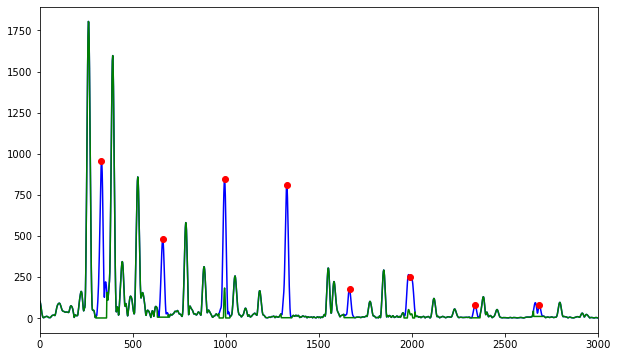

In [62]:
def F_cancelHarmonics(fs_hz, amps_ft, fs_h_k, amps_h, l_sec, n_fft, sr_hz):
    """
    inputs:
        - fftFreq_hz_v (N/2+1,): vector containing the FFT frequencies in Hz
        - fftAmpl_v (N/2+1,): vector containing the FFT amplitude 
        - harmoFreq_k_v: vector containing the position/index of the Harmonics (position in fftFreq_hz_v or fftAmpl_v)
        - harmoAmpl_v:  vector containing the Harmonic amplitudes
        - L_sec: window duration in seconds
        - Nfft: fft size
        - sr_hz: sampling rate
    outputs:
        - fftAmplSubtract_v (N/2+1,):  vector containing the FFT amplitude with amplitudes canceled at harmonic positions
    """

    c_w = 2.0 # === for a hanning window
    b_w_hz = c_w/(l_sec) # === this is the width at -3dB of the main lobe
    b_w_hz = 3*b_w_hz # === we extend it a bit since we want more than "at -3 dB"
    b_w_k = np.int(b_w_hz/sr_hz*n_fft)
    b_w_k = b_w_k + b_w_k % 2
    #
    a_k = fs_h_k - b_w_k//2
    b_k = fs_h_k + b_w_k//2
    #
    amps_hat_abs = np.array([np.mean([amps_h[max(0, h-1):min(h+1, amps_h.shape[0])]]) for h in np.arange(amps_h.shape[0])])

    amps_ft_corr = np.abs(amps_ft.copy())
    with np.nditer([a_k, b_k], flags=['f_index']) as it:
        for (a, b) in it:
            h = it.index
            is_sup = np.abs(amps_ft[fs_h_k[h]]) >= amps_hat_abs[h]
            corr_var = np.maximum(0, amps_ft_corr[a:b] - amps_hat_abs[h])
            corr_min = np.amin(np.abs(amps_ft[a:b]))
            amps_ft_corr[a:b] = corr_var if is_sup else corr_min
    return amps_ft_corr

amps_ft_corr = F_cancelHarmonics(fs_hz, amps_ft, fs_h_k, amps_h, l_sec, n_fft, sr_hz)
# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10,6))
plt.plot(fs_hz, amps_ft, 'b-')
plt.plot(fs_hz[fs_h_k], amps_h, 'ro')
# plt.plot(fs_hz[fs_h_k], harmoAmplSmooth_v, 'g+')
plt.plot(fs_hz, amps_ft_corr, 'g-')
plt.xlim((0,3000))
# +++++++++++++++++++++++++++++++

### Test 
Pour le signal audioFile = './_audio/A3C4E4G4_piano.wav' vous devriez obtenir

<IMG SRC='../_images/TP_multiPitch_04.png' width=600/>

## Critère d’arrêt

Les étapes précédentes (```F_getF0FromSpectre```,```F_getHarmonicsFromF0AndSpectre```,```F_cancelHarmonics```) sont ensuite itérées tant qu’un certain critère d’arrêt n’est pas vérifié.

Déterminer un critère d’arrêt qui vous permet d’arrêter l’itération lorsque le bon nombre de notes a été trouvé.

On testera l’algorithme sur les différents accords proposés.

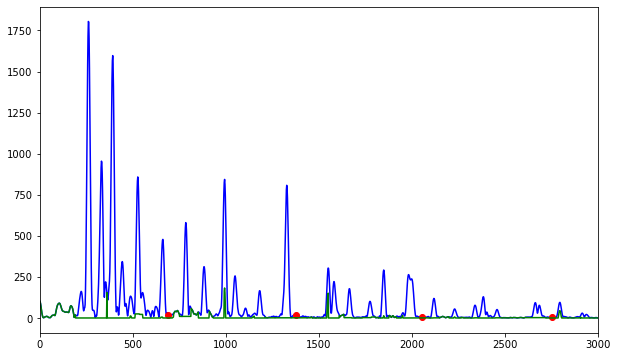

In [102]:
def synth(fs: np.ndarray, amps: np.ndarray, ts: np.ndarray) -> np.ndarray:
        t_ids, ep_ids = np.indices((ts.shape[0], fs.shape[0]))
        s_i = amps[ep_ids] * np.sin(2 * np.pi * fs[ep_ids] * ts[t_ids])
        return np.sum(s_i, axis=1)

def detect_pitch_multi(x: np.ndarray, sr_hz: float) -> Tuple[np.ndarray, np.ndarray]:
        #
        alpha = 10**-2
        beta = 5*10**-4
        h = 4
        l_sec = 0.1
        l_n = np.int64(l_sec*sr_hz)
        n_fft = 4 * ut.next_pow2(l_n) 
        f_min_hz = 50
        f_max_hz = 900
        #
        fs_hz, amps_ft = F_getSpectreFromAudio(x, l_n, n_fft, sr_hz)
        pred_func = lambda amps_ft_init, thresh: lambda amps_ft: np.amax(amps_ft)/np.amax(amps_ft_init) >= thresh
        thres = 0.1
        pred = pred_func(amps_ft, thres)
        amps_ft_corr = amps_ft.copy()
        f_0_hz_l = []
        amps_ft_l = []
        i = 0
        while pred(amps_ft_corr) and i < 10:
                fs_p_hz, p, f_0_hz = F_getF0FromSpectre(fs_hz, amps_ft_corr, h, f_min_hz, f_max_hz, n_fft, sr_hz)
                # add this f_0 to the list
                fs_h_k, amps_h = F_getHarmonicsFromF0AndSpectre(fs_hz, amps_ft_corr, f_0_hz, n_fft, sr_hz, alpha, beta)
                f_0_hz_l.append(f_0_hz)
                amps_ft_l.append(amps_ft_corr[fs_h_k[0]])
                amps_ft_corr = F_cancelHarmonics(fs_hz, amps_ft_corr, fs_h_k, amps_h, l_sec, n_fft, sr_hz)
                i += 1
        f_0_hz_v = np.array(f_0_hz_l)
        amps_ft_v = np.array(amps_ft_l)
        return f_0_hz_v, amps_ft_v
# sr_hz, x = audio_data['piano']['A4']
# sr_hz, x = audio_data['duo']['A3A4A5']
# sr_hz, x = audio_data['piano']['A3C4E4G4']
sr_hz, x = audio_data['trio']['Accord']

#
# +++++++++++++++++++++++++++++++
plt.figure(figsize=(10,6))
plt.plot(fs_hz, amps_ft, 'b-')
plt.plot(fs_hz[fs_h_k], amps_h, 'ro')
# plt.plot(fs_hz[fs_h_k], harmoAmplSmooth_v, 'g+')
plt.plot(fs_hz, amps_ft_corr, 'g-')
plt.xlim((0,3000))
# +++++++++++++++++++++++++++++++

l_synth_s = 3
ts = np.arange(0, l_synth_s, 1/sr_hz)
x_tilde = synth(f_0_hz_v, amps_ft_v, ts)

# ipd.Audio(x, rate=sr_hz)
ipd.Audio(x_tilde, rate=sr_hz)
# +++++++++++++++++++++++++++++++


# Bibliographie

- [1] A.P. Klapuri. Multipitch estimation and sound separation by the spectral smoothness principle. In Procee- dings of IEEE International Conference on Acoustics, Speech and Signal Processing, ICASSP, May 2001.
- [2] A.P. Klapuri. Multiple fundamental frequency estimation by harmonicity and spectral smoothness. IEEE Trans. Speech and Audio Processing, 11(6) :804–816, 2003.